# Exploring the Optimal Amount of Exemplars in  Siamese Convolutional Neural Networks

_Is one, two, or three-shot classification optimal for a learning task with a sparse dataset?_

#### Introduction 
Humans are pretty good at learning novel symbols based on extremely sparse experiences. 
You can show a person an unfamiliar symbol, e.g. ൹, and after this single exposure, they'll be able to easily verify if another symbol, e.g. ౿, is the same symbol or not.
While one-shot learning is enviable (it's flexible, it doesn't use a lot of input data), artificial neural networks aren't often built to do this.

However, recent work has demonstrated that one-shot learning is indeed possible for machine learning algorithms.
Some highlights:
-  Lake, Salakhutdinov, and Tenenbaum (2015) used _Hierarchical Bayesian Program Learning_, which decomposes input images of hand-written characters into their composite parts, just like a human mind would. 
-  Koch, Zemel, and Salakhutdinov (2015) were able to (almost) reproduce Lake et al's accuracy rate with a more conventional convolutional neural network within a siamese architecture, a model that takes two inputs, analyzes them using shared layers, and then merges the outputs from these two subnetworks. This model would take two images as inputs, and it would predict if the two images were _same_ (members of a common category) or _different_. 


In this exercise, I explore what effect the amount of exemplars has.
__Would a siamese convolutional neural network train faster with more than one exemplar?__
In other words, is two-shot learning any easier than one-shot?

#### Methods

I tested this on a siamese neural network, with two CNN subnetworks; their outputs are calculated with Manhattan distance.
Then, the model outputs a same/different judgement.
The model works by testing every case image against every categorical exemplar.


The shared layers in the dual inputs of this siamese model use a lightly-tweaked version of the model the Keras team  uses to classify MNIST characters (https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py), while the siamese architecture is based on Koch et al's.
The model was built in Keras, using Tensorflow as the backend.
It ran on a Google Compute Engine virtual machine with 8 virtual cores and 52GB of RAM.


This model uses Lake et al's Omniglot dataset.
Where the MNIST dataset includes 70,000 images of 10 categories of hand-written symbols, the Omniglot dataset presents a broader set of categories with a sparser number of images per category; in stark comparison to MNIST, it contains only 19280 hand-written images from 964 categories characters from (mostly non-fictional) natural languages. 
For this test, I subset the Omniglot dataset down to 20 categories.
For this exercise, I train 3 models; they have 1, 2, or 3 exemplars per category, to test one, two, or three-shot learning.
For each category, I pick 15 images to be categorized, (_cases_). 
Character categories are picked randomly, regardless of the languages they come from.


As with any model with a sparse dataset, over-fit is a very real hazard here.
I use two dropout layers, but regardless, the model's training accuracy is a lot less informative than are the validation and test accuracies.

Broadly speaking, this script:
-  Subsets the Omniglot dataset
-  Reads the images into a dictionary
-  Feeds these images to a model using generators


Model architecture:
-  Shared inputs (activation functions are all Relu)
    -  Convolutional layer with 32 filters
    -  Max-pooling layer
    -  Convolutional layer with 64 filters
    -  Max-pooling layer
    -  Convolutional layer with 64 layers
    -  Max-pooling layer
    -  Dropout @ 0.25
    -  (Flatten)
    -  Fully-connected layer with 128 nodes
    -  Dropout @ 0.5
-  The Manhattan distance between the two inputs is calculated
-  Output layer with 1 node and a sigmoid function


Possible outcomes:
-  If the two CNN subnetworks are abstracting the maximum amount of categorical information that they can from one exemplar, then adding more exemplars for each category won't improve the learning process.
If we were to anthropomorphasize this, this is akin to giving a child a dog, letting them learn all about the dog, and then giving them a second dog; if they learned everything they could about the category Dog from dog #1, then dog #2 isn't going to help them much.
If this were the case, then the learning rate that we'd see, per epoch, would be basically identical to the 1 exemplar control, because we're just adding redundant information.
-  If the two CNN subnetworks were __not__ abstracting the maximum amount of categorical information from one exemplar, then extra exemplars would either:
    -  Hamper the training process (the extra exemplars are now providing contradictory information), or
    -  Speed up the training process (the extra exemplars are now providing complimentary information)
    
Finally, if the networks are able to train with 2 or 3 exemplars, but the rate at which they train is altered, it will be interesting to see how this rate changes.
Will it be a linear change, or exponential, or something else?

In [10]:
%matplotlib inline

from keras import layers
from keras.layers import Input, Dense, Flatten, Dropout, Merge
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping
import keras.backend as K

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

import itertools, os, imageio, random, pickle

np.random.seed(1)
random.seed(1)

Using TensorFlow backend.


#### Define variables

In [11]:
# How many labels should be used?
subset_to = 20

# How many cases per label?
my_num_cases = 15

# Model
my_epoch_nums = 20
my_batch_size = 1000

#### Define functions

In [1]:
def find_images(directory_name):
    """
    Find all of the filenames, subdirectories for the images.
    Since images are organized by character type, we can basically just use their directories as their labels.
    """
    fns = []
    labels = []

    for root, subdirs, files in os.walk(directory_name):
        for fn in files:
            if fn.endswith('png'):
                fns.append('/'.join([root, fn]))

                fn_label = ' '.join(root.split('/')[1:])
                labels.append(fn_label)

    return np.array(fns), np.array(labels)

In [2]:
def get_indices_of_ex_and_ca(labels, indices, num_exemplars = 1, num_cases = 15):
    """
    For each unique character category, choose 1 or more images to serve as the 
    EXEMPLAR, and several images to serve as CASE images (ie images to be tested). 
    
    Run through each label, picking 1 (or more) exemplars and 15 case images.
    
    For each label, find the indices of the images that belong to this label.
    Randomly select a subset of these indices. These indices will be in random order.
    The first index/indices will refer to the images used as the exemplar(s); the rest will be indices of cases.
    Store these indices in arrays.
    
    Arguments:
        labels -- a list of the images' labels.
        indices -- an array of all of the images' indices.
    
    Returns:
        exemplar_indices -- an array of the indices of the exemplar images.
        case_indices -- an array of the indices of the case images.
    """

    num_both = num_exemplars + num_cases

    exemplar_indices = []
    case_indices = []

    for label in set(labels):
        # Find the indices where the label list contains our label.
        # Pick a subset of these indices.
        # First chosen index/indices = exemplar, rest = cases.
            sel = np.where(labels == label)[0]
            chosen_indices = np.random.choice(sel, num_both)

            local_exemplar_indices = chosen_indices[:num_exemplars].tolist()
            local_case_indices = chosen_indices[num_exemplars:].tolist()

            exemplar_indices += local_exemplar_indices
            case_indices += local_case_indices

    return np.array(case_indices).astype('int'), np.array(exemplar_indices).astype('int')


In [3]:
def create_generators_indices(a_case_array, exemplar_indices, labels):
    """
    Each case item will be tested against each exemplar.
    For either the training, validation, or test data, create 3 arrays for our siamese ANN:
    1. the order in which the cases should be fed into the model.
    2. the order in which the exemplars should be fed into the model.
    3. an array that notes if the case and exemplar belonged to the same category (0 or 1, for match or mismatch)
    
    Arguments:
        exemplar_indices -- The array of the exemplars' indices.
        a_case_array -- An array with either the training, val, or test indices of the cases.
        labels -- An array with the labels of the items.
        
    Returns:
        The 3 arrays noted above, which provide the generators with indices for cases, indices, and match/mismatch 
        information: 
        gi_case, gi_exemplar, gi_y
    """
    
    len_both_arrays = len(a_case_array) * len(exemplar_indices)
    
    gi_case = np.zeros(len_both_arrays)
    gi_exemplar = np.zeros(len_both_arrays)
    gi_y = np.zeros(len_both_arrays)

    i = 0
    for ci in a_case_array:
        for ei in exemplar_indices:
            gi_case[i] = ci
            gi_exemplar[i] = ei

            if labels[ci] == labels[ei]:
                gi_y[i] = 1

            i += 1
    return gi_case, gi_exemplar, gi_y

In [5]:
def Manhattan_distance(A,B):
    """
    Merge 2 tensors and calculate manhattan distance.
    This will make it really hard to save the model data (NB this is incompatible with the Keras model save function),
    but sometimes what's right to do isn't what's easy to do.
    https://github.com/keras-team/keras/issues/5541
    """
    return K.sum( K.abs( A-B),axis=1,keepdims=True)

#### Define generators

In [81]:
def gen_train_batch(gi_case_train, gi_exemplar_train, g_y_train, batch_size):  # gi_case_train, gi_exemplar_val
    """
    Create a generator that can output the data in batches. Takes in indices of case and 
    exemplar data. Yields the images that these indices correspond to.
    Also takes in y values (not indices of y values) that indicate if the exemplar and case
    match. Yields the y values.
    """
    while True:
        len_input = len(gi_case_train)
        for i in range(0, len_input, batch_size):

            case_indices = gi_case_train[i:i+batch_size]
            yield_these_case_pics = np.array([fn_dict[j] for j in case_indices])

            exemplar_indices = gi_exemplar_train[i:i+batch_size]
            yield_these_exemplar_pics = np.array([fn_dict[j] for j in exemplar_indices])

            # The y values are not indices, but real values.
            yield_these_y = g_y_train[i:i+batch_size].reshape(-1, 1)

            yield ([yield_these_case_pics, yield_these_exemplar_pics], yield_these_y)

In [82]:
def gen_val_batch(gi_case_val, gi_exemplar_val, g_y_val):
    """
    We'll just generate all the validation data at once.
    """
    
    yield_these_case_pics = np.array([fn_dict[j] for j in gi_case_val])
    yield_these_exemplar_pics = np.array([fn_dict[j] for j in gi_exemplar_val])
    yield_these_y = g_y_val.reshape(-1, 1)
    
    while True:
        yield ([yield_these_case_pics, yield_these_exemplar_pics], yield_these_y)

In [83]:
def test_generator(gi_case_test, gi_exemplar_test):
    """
    Yield one pair of images at a time.
    """
    for ci, ei in zip(gi_case_test, gi_exemplar_test):
        yield ([fn_dict[ci].reshape(1, 105, 105, 1), fn_dict[ei].reshape(1, 105, 105, 1)])

#### Prepare the data
Start by finding all of the Omniglot images' filenames.

In [84]:
fns, labels = find_images('omniglot')
print('There are %s images, representing %s unique characters.' %(len(fns), len(set(labels))))

There are 19280 images, representing 964 unique characters.


Subset the data to a smaller set categories which we set earlier. Otherwise, the dataset is intractably big for this test.

In [85]:
chosen_labels = random.sample(sorted(list(set(labels))), subset_to)
indices_to_shorten_with = np.array([np.where(labels == label) for label in chosen_labels]).flatten()

fns = fns[indices_to_shorten_with]
labels = labels[indices_to_shorten_with]

print('After subsetting, there are %s images, representing %s unique characters.' %(len(fns), len(set(labels))))

After subsetting, there are 400 images, representing 20 unique characters.


Read the images and store them in a dictionary. We'll refer to each image based on its index in the _fns_ list; use each image's index as its key. The values are representations of the images; np.arrays of 105x105x1

In [86]:
all_indices = np.arange(len(fns))
fn_dict = {i : imageio.imread(fns[i]).astype('float32').reshape(105, 105, 1)/255 
           for i in all_indices}

## 1 exemplar

In [87]:
# How many exemplars per label?
my_num_exemplars = 1

Shuffle all files, and randomly select one or more images from each category to serve as the exemplar. A user-defined number of images will serve as cases (the images which will be categorized vis a vis these exemplars).

In [88]:
case_indices, exemplar_indices = get_indices_of_ex_and_ca(labels = labels, 
                                                          indices = all_indices, 
                                                          num_exemplars = my_num_exemplars, 
                                                          num_cases = my_num_cases)
print('Ratio of exemplars to case studies is %s : %s' %(len(exemplar_indices), 
                                                       len(case_indices)))

Ratio of exemplars to case studies is 20 : 300


Let's take a look at the images we randomly chose to serve as exemplars.

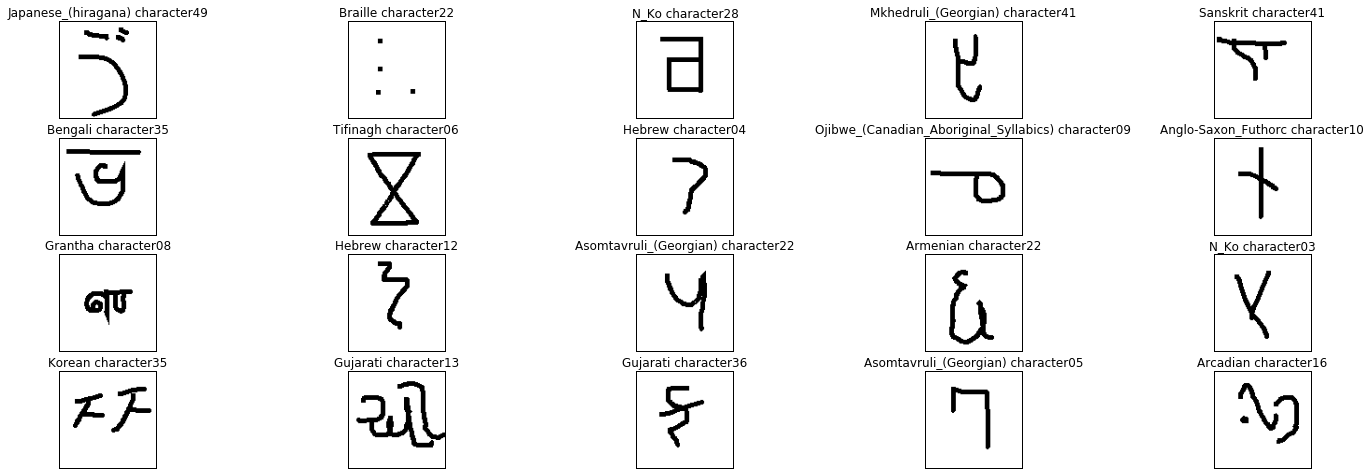

In [127]:
nrow = 4
ncol = 5
fig, axs = plt.subplots(nrow, ncol, figsize = (25, 8))
for i, ax in enumerate(fig.axes):
    j = exemplar_indices[i]
    ax.imshow(np.array(fn_dict[j]).reshape(105, 105), cmap='gray')
    ax.set_title(labels[j])
    ax.set_xticks([])
    ax.set_yticks([])

Looks pretty good. Unsurprisingly, given the breadth of the dataset, there's a healthy amount of variety here.

Calculate where to split the case data; 20% will be test data, and of the remainder, 20% will be validation data. This can be achieved by splitting the dataset into 3 chunks, split at 64% and at 80%.

In [16]:
len_to_split = len(case_indices)
split_test   = int(len_to_split * 0.8)  # between val and testing
split_val    = int(len_to_split * 0.64)  # between training and val

Split the cases into training, validation, and test sets. We want to know which case will be evaluated when.

In [17]:
singular_case_indices_train = case_indices[:split_val]
singular_case_indices_val   = case_indices[split_val:split_test]
singular_case_indices_test  = case_indices[:split_test]

Generator indices<br>
We'll feed the data into the model with a generator, but we'll predetermine the order with which the data will be fed in. Create arrays that note this order. The y arrays are not indices but real data- 0s and 1s, noting match and mismatch between the cases and exemplars.

In [18]:
gi_case_train, gi_exemplar_train, g_y_train = create_generators_indices(
    singular_case_indices_train, exemplar_indices, labels)

In [19]:
gi_case_val, gi_exemplar_val, g_y_val = create_generators_indices(
    singular_case_indices_val, exemplar_indices, labels)

In [20]:
gi_case_test, gi_exemplar_test, g_y_test = create_generators_indices(
    singular_case_indices_test, exemplar_indices, labels)

In [21]:
my_steps_per_epoch = len(g_y_train) / my_batch_size
validation_length = len(g_y_val)

#### Create the model

In [22]:
pic_a  = Input(shape=(105, 105, 1))
pic_b  = Input(shape=(105, 105, 1))

In [23]:
conv1  = Conv2D(32, kernel_size=(10, 10), activation='relu')
mp2    = MaxPooling2D((2, 2))
conv3  = Conv2D(64, kernel_size=(10, 10), activation='relu')
mp4    = MaxPooling2D((2, 2))
conv5  = Conv2D(64, kernel_size=(10, 10), activation='relu')
drop6  = Dropout(0.25)
flat7  = Flatten()
dense8 = Dense(128, activation='relu')
drop9  = Dropout(0.5)

In [6]:
# Twin inputs
output_a = drop9(dense8(flat7(drop6(conv5(mp4(conv3(mp2(conv1(pic_a)))))))))
output_b = drop9(dense8(flat7(drop6(conv5(mp4(conv3(mp2(conv1(pic_b)))))))))


# Merge
merged_vector = Merge(mode=lambda x:Manhattan_distance(x[0],x[1]), output_shape=lambda inp_shp:(inp_shp[0][0],1))([output_a, output_b])
predictions = layers.Dense(1, activation='sigmoid')(merged_vector)

# dnu
# merged_features = layers.concatenate([output_a, output_b], axis=-1)

In [24]:
model = Model([pic_a, pic_b], predictions)
# model.compile(optimizer='rmsprop',
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
# nb- I didn't end up using this.

early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=0, 
                               verbose=1, 
                               mode='auto')
callbacks_list = [early_stopping]

In [26]:
history_1 = model.fit_generator(gen_train_batch(gi_case_train, 
                                              gi_exemplar_train, 
                                              g_y_train, 
                                              batch_size = my_batch_size),
                             steps_per_epoch = my_steps_per_epoch,
                             epochs = my_epoch_nums, 
                             verbose = 1, 
                             validation_data = gen_val_batch(gi_case_val, 
                                                             gi_exemplar_val, 
                                                             g_y_val),
                             validation_steps = 1)

Epoch 1/20
4/3 [===============================] - 323s 81s/step - loss: 0.6943 - acc: 0.9268 - val_loss: 0.6592 - val_acc: 0.9448
Epoch 2/20
4/3 [===============================] - 320s 80s/step - loss: 0.4612 - acc: 0.7598 - val_loss: 0.6737 - val_acc: 0.9521
Epoch 3/20
4/3 [===============================] - 323s 81s/step - loss: 0.3047 - acc: 0.9268 - val_loss: 0.6574 - val_acc: 0.9500
Epoch 4/20
4/3 [===============================] - 320s 80s/step - loss: 0.2487 - acc: 0.9500 - val_loss: 0.6070 - val_acc: 0.9500
Epoch 5/20
4/3 [===============================] - 320s 80s/step - loss: 0.2343 - acc: 0.9500 - val_loss: 0.6066 - val_acc: 0.9500
Epoch 6/20
4/3 [===============================] - 321s 80s/step - loss: 0.2205 - acc: 0.9500 - val_loss: 0.5958 - val_acc: 0.9500
Epoch 7/20
4/3 [===============================] - 324s 81s/step - loss: 0.2165 - acc: 0.9500 - val_loss: 0.5338 - val_acc: 0.9500
Epoch 8/20
4/3 [===============================] - 322s 80s/step - loss: 0.2109 - a

In [27]:
model.save('mod_1x.h5')

history1 = dict(history_1.history)
pickle_out = open("dict1.pickle","wb")
pickle.dump(history1, pickle_out)
pickle_out.close()

#### Evaluate the model
Find the test accuracy.

In [28]:
num_test_steps = len(gi_case_test)
y_test_1x = g_y_test
y_fit_1x = model.predict_generator(test_generator(gi_case_test, gi_exemplar_test), 
                                steps = num_test_steps)

y_fit_round_1x = (y_fit_1x.flatten() >= .5).astype('int')
test_accuracy = (y_fit_round_1x == y_test_1x).mean()
print('Test accuracy: %s' %test_accuracy)

Test accuracy: 0.95


## 2 Exemplars

In [191]:
my_num_exemplars = 2

case_indices, exemplar_indices = get_indices_of_ex_and_ca(labels = labels, 
                                                          indices = all_indices, 
                                                          num_exemplars = my_num_exemplars, 
                                                          num_cases = my_num_cases)
print('Ratio of exemplars to case studies is %s : %s' %(len(exemplar_indices), 
                                                       len(case_indices)))

Ratio of exemplars to case studies is 40 : 300


Let's visualize the exemplars. Now, we have 2 per category.

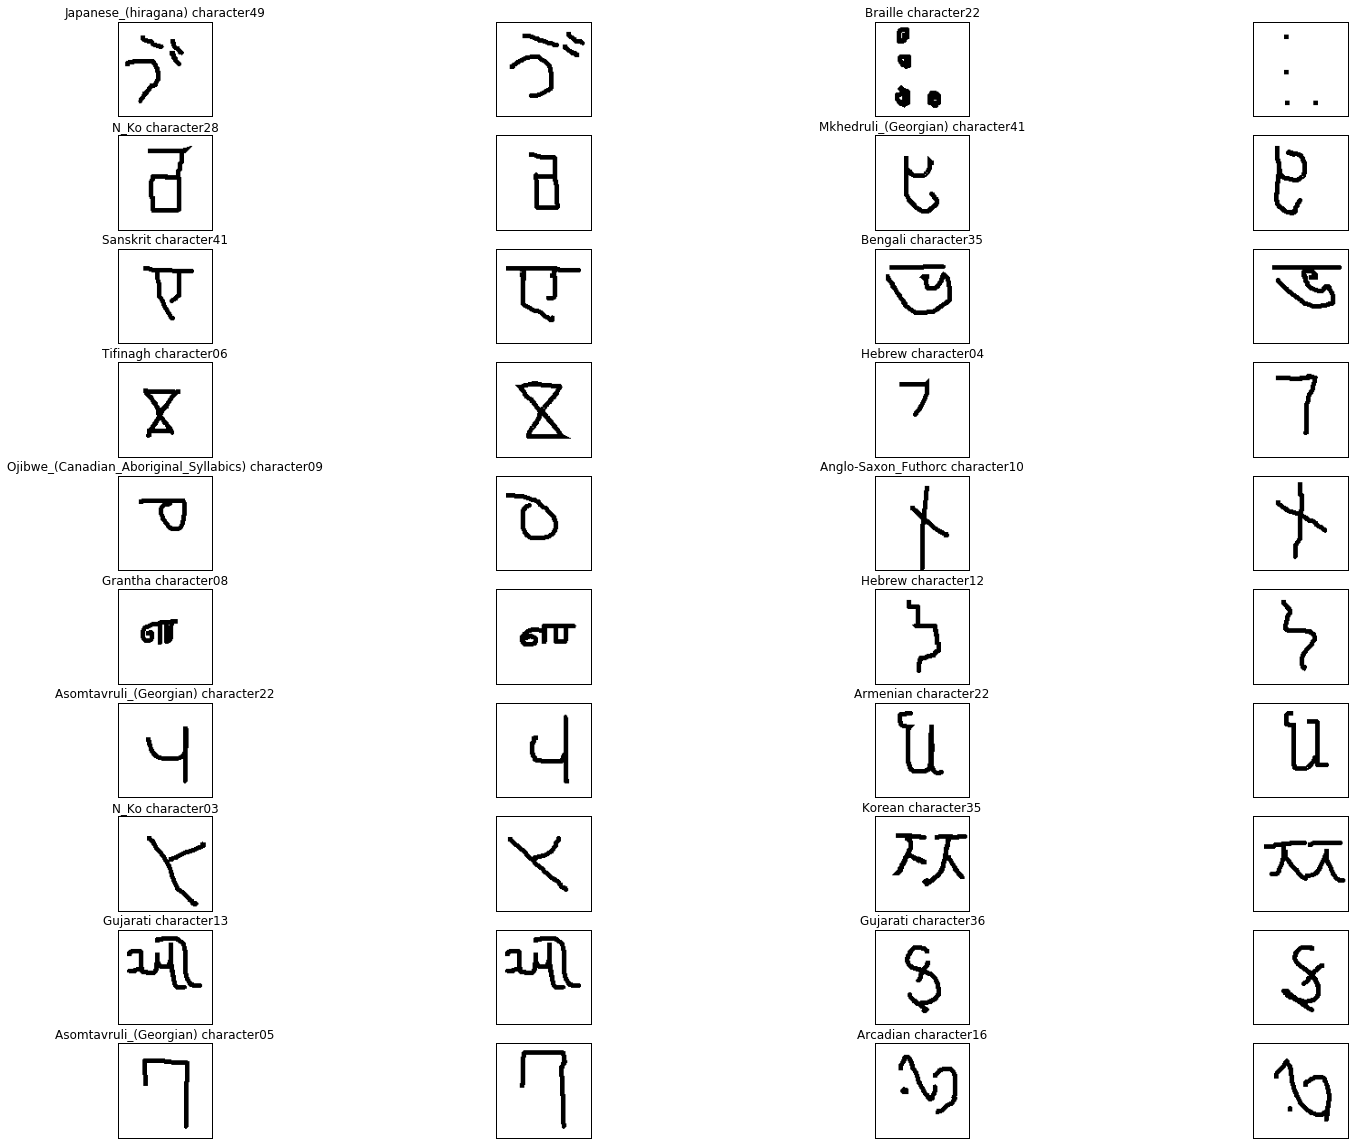

In [194]:
nrow = 10
ncol = 4
fig, axs = plt.subplots(nrow, ncol, figsize = (26, 20))
for i, ax in enumerate(fig.axes):
    j = exemplar_indices[i]
    ax.imshow(np.array(fn_dict[j]).reshape(105, 105), cmap='gray')
    if i % 2 == 0:
        ax.set_title(labels[j])
    ax.set_xticks([])
    ax.set_yticks([])

Things look pretty good- the differences between categories is much greater than the difference within categories.

In [27]:
len_to_split = len(case_indices)
split_test   = int(len_to_split * 0.8)  # between val and testing
split_val    = int(len_to_split * 0.64)  # between training and val

singular_case_indices_train = case_indices[:split_val]
singular_case_indices_val   = case_indices[split_val:split_test]
singular_case_indices_test  = case_indices[:split_test]

gi_case_train, gi_exemplar_train, g_y_train = create_generators_indices(
    singular_case_indices_train, exemplar_indices, labels)

gi_case_val, gi_exemplar_val, g_y_val = create_generators_indices(
    singular_case_indices_val, exemplar_indices, labels)

gi_case_test, gi_exemplar_test, g_y_test = create_generators_indices(
    singular_case_indices_test, exemplar_indices, labels)

my_steps_per_epoch = len(g_y_train) / my_batch_size
validation_length = len(g_y_val)

In [8]:
pic_a  = Input(shape=(105, 105, 1))
pic_b  = Input(shape=(105, 105, 1))

conv1  = Conv2D(32, kernel_size=(10, 10), activation='relu')
mp2    = MaxPooling2D((2, 2))
conv3  = Conv2D(64, kernel_size=(10, 10), activation='relu')
mp4    = MaxPooling2D((2, 2))
conv5  = Conv2D(64, kernel_size=(10, 10), activation='relu')
drop6  = Dropout(0.25)
flat7  = Flatten()
dense8 = Dense(128, activation='relu')
drop9  = Dropout(0.5)

# Twin inputs
output_a = drop9(dense8(flat7(drop6(conv5(mp4(conv3(mp2(conv1(pic_a)))))))))
output_b = drop9(dense8(flat7(drop6(conv5(mp4(conv3(mp2(conv1(pic_b)))))))))


# Merge
merged_vector = Merge(mode=lambda x:Manhattan_distance(x[0],x[1]), output_shape=lambda inp_shp:(inp_shp[0][0],1))([output_a, output_b])
predictions = layers.Dense(1, activation='sigmoid')(merged_vector)

model2 = Model([pic_a, pic_b], predictions)
# model.compile(optimizer='rmsprop',
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [31]:
history_2 = model2.fit_generator(gen_train_batch(gi_case_train, 
                                              gi_exemplar_train, 
                                              g_y_train, 
                                              batch_size = my_batch_size),
                             steps_per_epoch = my_steps_per_epoch,
                             epochs = 20, 
                             verbose = 1, 
                             validation_data = gen_val_batch(gi_case_val, 
                                                             gi_exemplar_val, 
                                                             g_y_val),
                             validation_steps = 1)

Epoch 1/20
8/7 [===============================] - 667s 83s/step - loss: 0.7318 - acc: 0.9500 - val_loss: 0.7657 - val_acc: 0.9500
Epoch 2/20
8/7 [===============================] - 669s 84s/step - loss: 0.8059 - acc: 0.9500 - val_loss: 0.7657 - val_acc: 0.9500
Epoch 3/20
8/7 [===============================] - 667s 83s/step - loss: 0.8059 - acc: 0.9500 - val_loss: 0.7657 - val_acc: 0.9500
Epoch 4/20
8/7 [===============================] - 663s 83s/step - loss: 0.8059 - acc: 0.9500 - val_loss: 0.7657 - val_acc: 0.9500
Epoch 5/20
8/7 [===============================] - 656s 82s/step - loss: 0.8059 - acc: 0.9500 - val_loss: 0.7657 - val_acc: 0.9500
Epoch 6/20
8/7 [===============================] - 653s 82s/step - loss: 0.8059 - acc: 0.9500 - val_loss: 0.7657 - val_acc: 0.9500
Epoch 7/20
8/7 [===============================] - 653s 82s/step - loss: 0.8059 - acc: 0.9500 - val_loss: 0.7657 - val_acc: 0.9500
Epoch 8/20
8/7 [===============================] - 653s 82s/step - loss: 0.8059 - a

In [32]:
model2.save('mod_2x.h5')

history2 = dict(history_2.history)
pickle_out = open("dict2.pickle","wb")
pickle.dump(history2, pickle_out)
pickle_out.close()

#### Evaluate the model

In [34]:
num_test_steps = len(gi_case_test)
y_test_2x = g_y_test
y_fit_2x = model2.predict_generator(test_generator(gi_case_test, gi_exemplar_test), 
                                steps = num_test_steps)

y_fit_round_2x = (y_fit_2x.flatten() >= .5).astype('int')
test_accuracy = (y_fit_round_2x == y_test_2x).mean()
print('Test accuracy: %s' %test_accuracy)

Test accuracy: 0.95


_Without_ rounding, what was the mean value of the last layer?

In [195]:
y_fit_2x.mean()

0.0010904659

## 3 Exemplars

In [172]:
my_num_exemplars = 3

case_indices, exemplar_indices = get_indices_of_ex_and_ca(labels = labels, 
                                                          indices = all_indices, 
                                                          num_exemplars = my_num_exemplars, 
                                                          num_cases = my_num_cases)
print('Ratio of exemplars to case studies is %s : %s' %(len(exemplar_indices), 
                                                       len(case_indices)))

Visualize the exemplars.

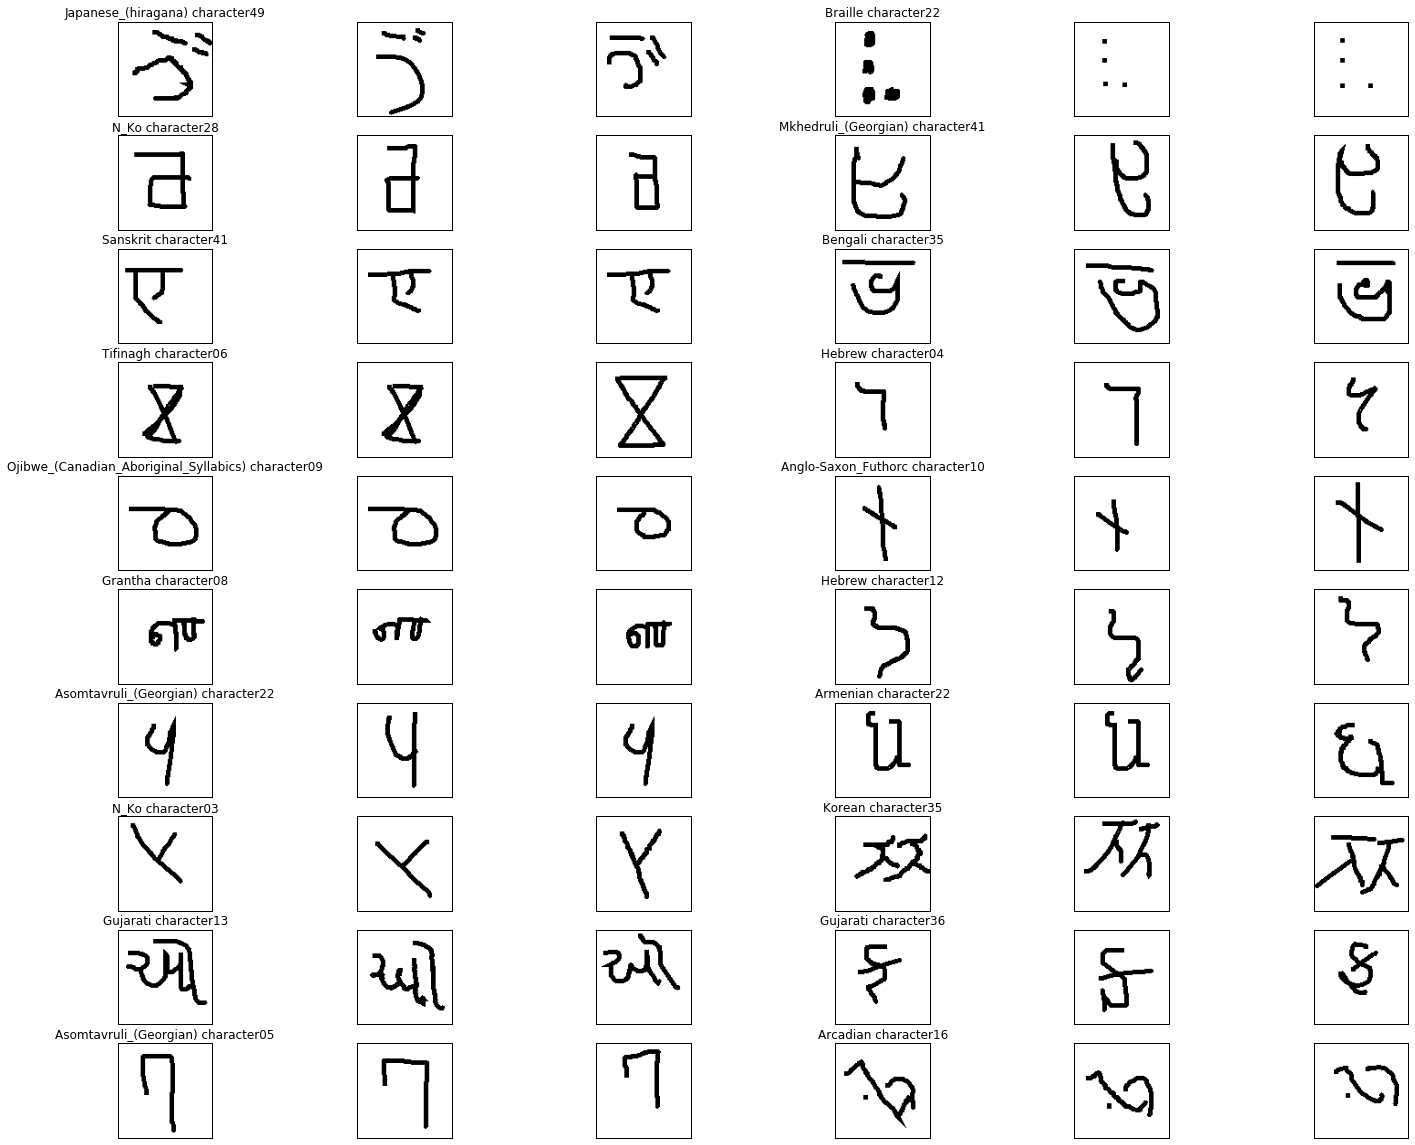

In [190]:
nrow = 10
ncol = 6
fig, axs = plt.subplots(nrow, ncol, figsize = (25, 20))
for i, ax in enumerate(fig.axes):
    j = exemplar_indices[i]
    ax.imshow(np.array(fn_dict[j]).reshape(105, 105), cmap='gray')
    if i % 3 == 0:
        ax.set_title(labels[j])
    ax.set_xticks([])
    ax.set_yticks([])

In [28]:
len_to_split = len(case_indices)
split_test   = int(len_to_split * 0.8)  # between val and testing
split_val    = int(len_to_split * 0.64)  # between training and val

singular_case_indices_train = case_indices[:split_val]
singular_case_indices_val   = case_indices[split_val:split_test]
singular_case_indices_test  = case_indices[:split_test]

gi_case_train, gi_exemplar_train, g_y_train = create_generators_indices(
    singular_case_indices_train, exemplar_indices, labels)

gi_case_val, gi_exemplar_val, g_y_val = create_generators_indices(
    singular_case_indices_val, exemplar_indices, labels)

gi_case_test, gi_exemplar_test, g_y_test = create_generators_indices(
    singular_case_indices_test, exemplar_indices, labels)

my_steps_per_epoch = len(g_y_train) / my_batch_size
validation_length = len(g_y_val)

In [9]:
pic_a  = Input(shape=(105, 105, 1))
pic_b  = Input(shape=(105, 105, 1))

conv1  = Conv2D(32, kernel_size=(10, 10), activation='relu')
mp2    = MaxPooling2D((2, 2))
conv3  = Conv2D(64, kernel_size=(10, 10), activation='relu')
mp4    = MaxPooling2D((2, 2))
conv5  = Conv2D(64, kernel_size=(10, 10), activation='relu')
drop6  = Dropout(0.25)
flat7  = Flatten()
dense8 = Dense(128, activation='relu')
drop9  = Dropout(0.5)

# Twin inputs
output_a = drop9(dense8(flat7(drop6(conv5(mp4(conv3(mp2(conv1(pic_a)))))))))
output_b = drop9(dense8(flat7(drop6(conv5(mp4(conv3(mp2(conv1(pic_b)))))))))

# Merge
merged_vector = Merge(mode=lambda x:Manhattan_distance(x[0],x[1]), output_shape=lambda inp_shp:(inp_shp[0][0],1))([output_a, output_b])
predictions = layers.Dense(1, activation='sigmoid')(merged_vector)


model3 = Model([pic_a, pic_b], predictions)

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
history_3 = model3.fit_generator(gen_train_batch(gi_case_train, 
                                              gi_exemplar_train, 
                                              g_y_train, 
                                              batch_size = my_batch_size),
                             steps_per_epoch = my_steps_per_epoch,
                             epochs = 10,  # shorten to ten 
                             verbose = 1, 
                             validation_data = gen_val_batch(gi_case_val, 
                                                             gi_exemplar_val, 
                                                             g_y_val),
                             validation_steps = 1)

Epoch 1/10
12/11 [===============================] - 972s 81s/step - loss: 0.7896 - acc: 0.9499 - val_loss: 0.2871 - val_acc: 0.9531
Epoch 2/10
12/11 [===============================] - 956s 80s/step - loss: 0.8070 - acc: 0.9499 - val_loss: 0.7577 - val_acc: 0.9531
Epoch 3/10
12/11 [===============================] - 959s 80s/step - loss: 0.8070 - acc: 0.9499 - val_loss: 0.7577 - val_acc: 0.9531
Epoch 4/10
12/11 [===============================] - 958s 80s/step - loss: 0.8070 - acc: 0.9499 - val_loss: 0.7577 - val_acc: 0.9531
Epoch 5/10
12/11 [===============================] - 963s 80s/step - loss: 0.8070 - acc: 0.9499 - val_loss: 0.7577 - val_acc: 0.9531
Epoch 6/10
12/11 [===============================] - 964s 80s/step - loss: 0.8070 - acc: 0.9499 - val_loss: 0.7577 - val_acc: 0.9531
Epoch 7/10
12/11 [===============================] - 959s 80s/step - loss: 0.8070 - acc: 0.9499 - val_loss: 0.7577 - val_acc: 0.9531
Epoch 8/10
12/11 [===============================] - 957s 80s/step - 

In [169]:
model3.save('mod_3x.h5')

history3 = dict(history_3.history)
pickle_out = open("dict3.pickle","wb")
pickle.dump(history3, pickle_out)
pickle_out.close()

#### Evaluate the model

In [33]:
num_test_steps = len(gi_case_test)
y_test_3x = g_y_test
y_fit_3x = model3.predict_generator(test_generator(gi_case_test, gi_exemplar_test), 
                                steps = num_test_steps)

y_fit_round_3x = (y_fit_3x.flatten() >= .5).astype('int')
test_accuracy3x = (y_fit_round_3x == y_test_3x).mean()
print('Test accuracy: %s' %test_accuracy3x)

Test accuracy: 0.952152777778


_Without_ rounding, what was the mean value of the last layer?

In [34]:
y_fit_3x.mean()

0.0010927633

## Comparison of the three models
Plot training epochs v loss (nb- lower loss is better)

In [52]:
x_epochs1 = np.arange(1, 21)
train1 = history1['loss']
val1 = history1['val_loss']

x_epochs2 = np.arange(1, 21)
train2 = history2['loss']
val2 = history2['val_loss']

x_epochs3 = np.arange(1, 11)
train3 = history3['loss']
val3 = history3['val_loss']

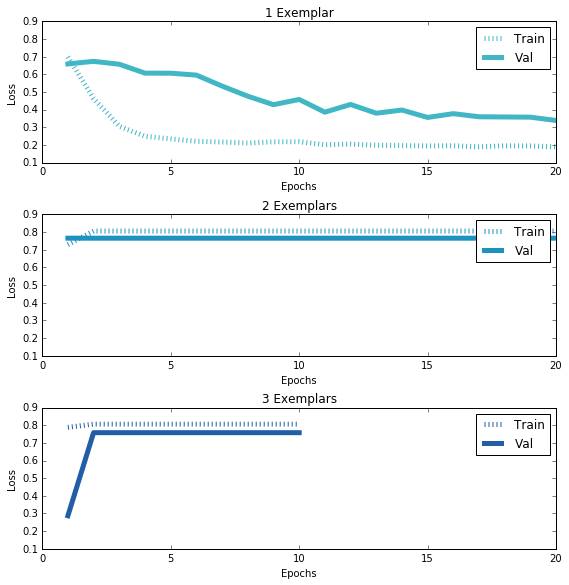

In [56]:
fig = plt.figure(figsize = (8, 8))

ax1 = plt.subplot(311)
ax1.set_xlim([1, 20])
ax1.set_ylim([0, 1])

ax2 = plt.subplot(312, sharex = ax1, sharey = ax1)
ax3 = plt.subplot(313, sharex = ax1, sharey = ax1)

ax1.plot(x_epochs1, train1, color = '#41b6c4', linestyle = 'dotted', label = 'Train', linewidth = 5)
ax1.plot(x_epochs1, val1, color = '#41b6c4', label = 'Val', linewidth = 5)
ax1.legend(loc = 1)
ax1.set_title('1 Exemplar')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(x_epochs2, train2, color = '#1d91c0', linestyle = 'dotted', label = 'Train', linewidth = 5)
ax2.plot(x_epochs2, val2, color = '#1d91c0', label = 'Val', linewidth = 5)
ax2.legend(loc = 1)
ax2.set_title('2 Exemplars')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')


fig.tight_layout()
ax3.plot(x_epochs3, train3, color = '#225ea8', linestyle = 'dotted', label = 'Train', linewidth = 5)
ax3.plot(x_epochs3, val3, color = '#225ea8', label = 'Val', linewidth = 5)
ax3.legend(loc = 1)
ax3.set_title('3 Exemplars')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')

The one-shot learning model vastly outperformed the other models.
The 2 and 3 exemplar models never improve in terms of loss; they get worse, and then they plateau.
It looks like having more than 1 exemplar simply confuses the networks.

It's a bit suspicious that models that look so underwhelming in terms of loss should look so good in terms of test accuracy; all 3 models had test accuracies right around 95%. What's going on here?

#### Confusion Matrix
Let's look at model 2, which is our first model where things went off the rails.

In [181]:
cm = confusion_matrix(y_test_2x, 
                np.round(y_fit_2x)); cm

array([[9120,    0],
       [ 480,    0]])

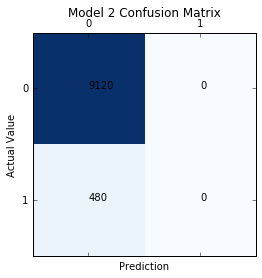

In [179]:
plt.matshow(cm, cmap='Blues')
for a in range(2):
    for b in range(2):
        val = cm[b,a]
        plt.annotate(val, xy = (a,b))
plt.title('Model 2 Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual Value')

Recall that according to this architecture, each image was categorized implicitly; if an image was tested against an image from the same category, the combination of the two should warrant a 1 (same), and if they were from different categories, they should warrant a 0 (different). 

This confusion matrix from model 2 demonstrates something quite logical; if every image is tested against every exemplar, but every image only belongs to one category, then a really safe prediction is to fit _every_ value as 0. And this is what we see here; model 2 never predicted that any two images belonged to the same category. Model 2 performed exactly as well as a typewriter with a broken '0' key.

#### Conclusion

It's quite impressive that one fit a proven CNN into a siamese framework and create a promising one-shot image classifier.
It's also good to know that one-shot learning is easier to train on than is two or three shot learning.

It's worth thinking about why between one-shot learning, and conventional (thousands, millions of shots) learning, there's this territory where these models have so much trouble.
Why was 2 or 3-shot learning so hard?

Possible ways to move forward with two or three-shot learning:
-  __The cost function should be tweaked.__
If a type-2 error (missing a match) were a lot more costly than a type-1 error (predicting a match where there isn't one), then the models with more than 1 exemplar might start to perform a lot better.
- __There should be more levels of abstraction.__
Tweaking the fully-connected layers after the convolutional layers might allow the model to better abstract the categorical information.
- __Other exemplars would work better.__
Finally, I chose exemplars at random, but according to Exemplar Theory (Smith & Medin, 1981; Murphy, 2004), exemplars should be somewhat meaningful representatives of their categories. 
If one were to represent, say, all birds with an emu, this would be very odd, just as if one were to represent all buildings with a barrel that a rat lived in.
This is because emus and barrels don't have a lot in common with the birds and buildings we deal with on a day-to-day basis.

#### Works Cited
-  Koch, G., Zemel, R., & Salakhutdinov, R. (2015). _Siamese neural networks for one-shot image recognition_. In ICML Deep Learning Workshop (Vol. 2).
-  Lake, B. M., Salakhutdinov, R., & Tenenbaum, J. B. (2015). _Human-level concept learning through probabilistic program induction_. Science, 350(6266), 1332-1338.
-  Murphy, G. (2004). _The big book of concepts_. MIT press.
-  Smith, E. E., & Medin, D. L. (1981). _Categories and concepts_ (Vol. 9). Cambridge, MA: Harvard University Press.
